# IMPORTANT

This notebook relies on some data that were too big to upload to GitHub. The necessary files can be downloaded at https://files.ipd.uw.edu/pub/SMART_MHC_2025/01_select_hits-00_ngs_processing-all_counts.csv and
https://files.ipd.uw.edu/pub/SMART_MHC_2025/01_select_hits-00_ngs_processing-all_matches.csv these files should be downloaded directly into this directory.

Note: these files are the same as those referenced in 01_select_hits/00_ngs_processing/README.txt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

def line(x, slope):
    return slope*x

In [2]:
all_counts = pd.read_csv('01_select_hits-00_ngs_processing-all_counts.csv',index_col=0)
count_cols = [x for x in all_counts.columns if 'count' in x]
vals = all_counts[count_cols].values
vals[np.isnan(vals)] = 0.5
all_counts[count_cols] = vals

matching_df = pd.read_csv('01_select_hits-00_ngs_processing-all_matches.csv')
name_convert = pd.read_csv('selected_designs_with_metrics_renamed.csv')

print(len(all_counts),len(matching_df),len(name_convert))
all_counts = all_counts.merge(matching_df,left_on='name',right_on='query_name',how='outer')
all_counts = all_counts.merge(name_convert,left_on='match_name',right_on='short_name',how='left')
print(len(all_counts))

339677 339677 10052
339677


In [3]:
for lib in ['exp','pep','TCR-plus-pep','TCR-minus-pep','TCR-plus-pep-plus-pep']:
    
    rep1 = all_counts['counts_'+lib+'1']
    rep2 = all_counts['counts_'+lib+'2']
    slope,var = curve_fit(line,rep1,rep2)
    
    close_to_line = np.abs(np.log10(rep1) - np.log10(rep2) + np.log10(slope))/np.sqrt(2) < 0.5
    enough_counts = (rep1 > 1) & (rep2 > 1)
    good_idx = close_to_line & enough_counts
    
    all_counts.insert(len(all_counts.columns),lib+'_filter',good_idx)

In [4]:
filter_cols = [x for x in all_counts.columns if 'filter' in x]
filtered = all_counts[np.any(all_counts[filter_cols].values, axis=1)]

In [5]:
lib_names = ['exp','pep','TCR-plus-pep','TCR-minus-pep','TCR-plus-pep-plus-pep']
parent = {
    'exp':'naive',
    'pep':'exp',
    'TCR-plus-pep':'pep',
    'TCR-minus-pep':'pep',
    'TCR-plus-pep-plus-pep':'TCR-plus-pep',
}
for i,lib in enumerate(lib_names):
    rep1 = filtered['counts_'+lib+'1'].copy()
    rep2 = filtered['counts_'+lib+'2'].copy()
    
    rep1[rep1<1] = 0
    rep2[rep2<1] = 0
    tot = rep1+rep2
    tot[tot==0] = 0.5
    
    frac = tot/np.sum(tot)
    
    if lib == 'exp':
        frac_prev = filtered['counts_naive']/np.sum(filtered['counts_naive'])
    else:
        rep1_prev = filtered['counts_'+parent[lib]+'1'].copy()
        rep2_prev = filtered['counts_'+parent[lib]+'2'].copy()
        
        rep1_prev[rep1_prev<1] = 0
        rep2_prev[rep2_prev<1] = 0
        tot_prev = rep1_prev+rep2_prev
        tot_prev[tot_prev==0] = 0.5
        
        frac_prev = tot_prev/np.sum(tot_prev)
        
    filtered.insert(len(filtered.columns), lib+'_rel_enrich', frac/frac_prev)

In [6]:
perfect_matches = filtered[np.sum(filtered[['mismatches_alignment','mismatches_query']],axis=1)==0]
print(len(perfect_matches))

5435


In [7]:
rif_score_df = pd.read_csv('native_rif_scores.csv')
perfect_matches = perfect_matches.merge(rif_score_df,left_on='name_y',right_on='name',how='left')
print(len(perfect_matches))

5435


In [8]:
perfect_matches.columns

Index(['AA', 'counts_TCR-plus-pep-plus-pep2', 'counts_TCR-plus-pep1',
       'counts_TCR-plus-pep2', 'counts_pep1', 'counts_TCR-minus-pep1',
       'counts_naive', 'counts_pep2', 'counts_TCR-minus-pep2', 'counts_exp2',
       'counts_TCR-plus-pep-plus-pep1', 'counts_exp1', 'name_x',
       'Unnamed: 0_x', 'query_name', 'query_len', 'hit_len', 'match_name',
       'mismatches_query', 'mismatches_alignment', 'algn_len', 'score',
       'e_val', 'Unnamed: 0_y', 'Unnamed: 0.1', 'SCORE:', 'total_score',
       'binder_blocked_sap', 'contact_molec_sq5_ap_target',
       'contact_molec_sq5_apap_target', 'contact_molecular_surface_ap_target',
       'contact_molecular_surface_apap_target', 'contact_patch', 'ddg',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
     

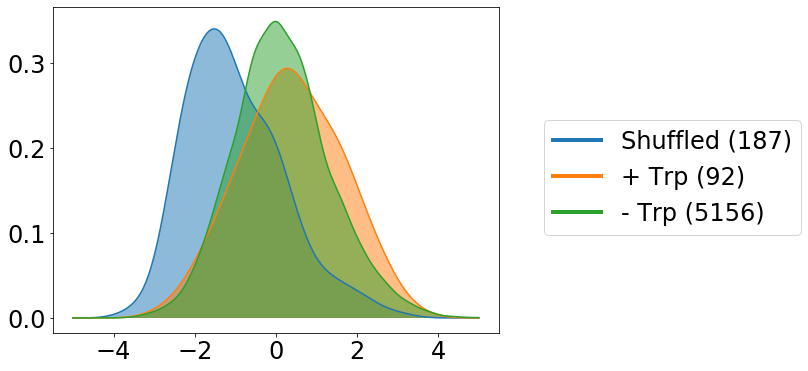

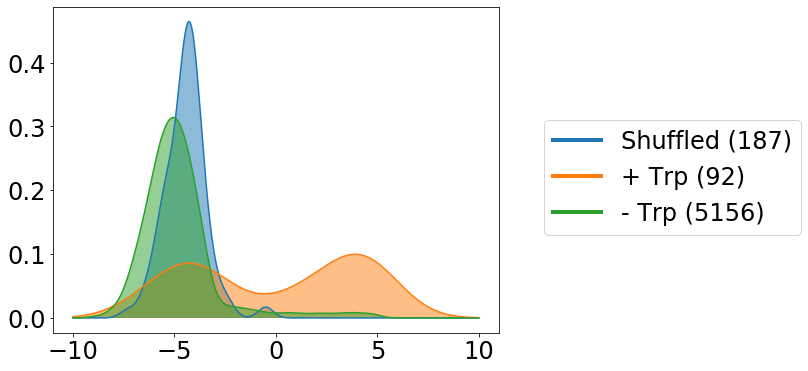

In [22]:
is_scramble = perfect_matches['match_name'].apply(lambda x: 'shuf' in str(x))
good_trp = (perfect_matches['just_trp_rif_hyd-ddg'] < -3) & ~np.isnan(perfect_matches['just_trp_rif_hyd-ddg'])
bad_trp = (perfect_matches['just_trp_rif_hyd-ddg'] >= -3) & ~np.isnan(perfect_matches['just_trp_rif_hyd-ddg'])

subsets = {
    'Shuffled': is_scramble,
    '+ Trp': good_trp & ~is_scramble,
    '- Trp': bad_trp & ~is_scramble
}


xlim = [[-5,5],[-10,10]]
yticks = [[0,0.1,0.2,0.3],[0,0.1,0.2,0.3,0.4]]
xticks = [[-4,-2,0,2,4],[-10,-5,0,5,10]]
for i,sort in enumerate(['exp','pep']):
    plt.figure(figsize=[8,6])
    x = np.linspace(*xlim[i],5000)
    for subset in subsets:
        data = np.log2(perfect_matches.loc[subsets[subset],f'{sort}_rel_enrich'])
        kde = gaussian_kde(data)
        plt.plot(x,kde.evaluate(x),label=f'{subset} ({sum(subsets[subset])})')
        plt.fill_between(x,kde.evaluate(x),alpha=0.5)
        
    leg = plt.legend(fontsize=24,loc=[1.1,0.3])
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.xticks(xticks[i],fontsize=24)
    plt.yticks(yticks[i],fontsize=24)
    plt.savefig(f'{sort}_enrichment_kde.png',dpi=1000,bbox_inches='tight')

In [10]:
len(perfect_matches)

5435

In [11]:
sum(~np.isnan(perfect_matches['just_trp_rif_hyd-ddg']))

5248

In [12]:
sum((perfect_matches['just_trp_rif_hyd-ddg'] < -3) & (np.log10(perfect_matches['pep_rel_enrich']) > 0))

49

In [13]:
sum((perfect_matches['just_trp_rif_hyd-ddg'] >= -3) & (np.log10(perfect_matches['pep_rel_enrich']) > 0))

204

In [14]:
sum((perfect_matches['just_trp_rif_hyd-ddg'] < -3) & (np.log10(perfect_matches['pep_rel_enrich']) <= 0))

43

In [15]:
sum((perfect_matches['just_trp_rif_hyd-ddg'] >= -3) & (np.log10(perfect_matches['pep_rel_enrich']) <= 0))

4952

In [16]:
sum(perfect_matches['match_name'].apply(lambda x: 'shuf' in str(x)) & (np.log10(perfect_matches['pep_rel_enrich']) > 0))

0

In [17]:
perfect_matches

,AA,counts_TCR-plus-pep-plus-pep2,counts_TCR-plus-pep1,counts_TCR-plus-pep2,counts_pep1,counts_TCR-minus-pep1,counts_naive,counts_pep2,counts_TCR-minus-pep2,counts_exp2,...,Unnamed: 0,name,full_native_rif_score,full_native_rif_bb-hbond,full_native_rif_hyd-cont,full_native_rif_hyd-ddg,just_trp_rif_score,just_trp_rif_bb-hbond,just_trp_rif_hyd-cont,just_trp_rif_hyd-ddg
0,TEIARRSVEELLEEAKHIDDPKRRFELLVLAQLVAEANNDPELERL...,6659.0,1321.0,2354.0,1712.0,1861.0,12.0,2699.0,2991.0,92.0,...,7611.0,HHH_b2_04759_000000178_std_0001_0001,12.763,0.0,0.0,-0.0,12.763,0.0,0.0,-0.0
1,SLEEAVRILLEKARKIEDEREREDVLILARLAAEAADDPELEKLVE...,2779.0,2155.0,4346.0,1736.0,3010.0,27.0,3248.0,3293.0,109.0,...,5756.0,HHH_b2_08092_000000297_std_0001_0001,-1.348,0.0,0.0,-0.0,-1.348,0.0,0.0,-0.0
2,SVAEEAVKHLLEKAKKIPDPKQRRDVLILAEIAARAYNNEELEELV...,2635.0,3130.0,2328.0,1284.0,1435.0,15.0,932.0,1042.0,73.0,...,6973.0,HHH_b2_04605_000000257_std_0001_0001,-1.452,0.0,0.0,-0.0,-1.452,0.0,0.0,-0.0
3,DSEELFRRAEERLKELERQGDKTQARFLAFRVVLELRELGDPELAE...,2228.0,1499.0,677.0,1752.0,2292.0,14.0,1194.0,982.0,109.0,...,8925.0,m_HHH_b1_07716_000000255_std_0001_22_34_H_._HH...,-1.009,0.0,0.0,-0.0,-1.009,0.0,0.0,-0.0
4,SREEVRRLLEEAKKIDDPHERNEALWRALAIALLSDDPELAELVVR...,2074.0,2074.0,1602.0,1792.0,1647.0,8.0,1312.0,1379.0,64.0,...,8638.0,HHH_b2_03012_000000029_std_0001_0001,-0.426,0.0,0.0,-0.0,-0.426,0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,DEEVQRLVEELVREFNLSEEQEVILRILAKILDEFGFSPEEVKELL...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2.0,...,3854.0,HHH_b2_05050_000000158_std_0001_0001,-0.111,0.0,0.0,-0.0,-0.111,0.0,0.0,-0.0
5431,DEEEAKRLLEEVRRLEEKGDHKAVSQLALRIFLLLEEYNNPELKKI...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2.0,...,364.0,HHH_b1_03161_000000035_std_0001_0001,0.430,0.0,0.0,-0.0,0.430,0.0,0.0,-0.0
5432,DEEEREVKRLIEEAERDPRHARELLFRALQIALEYNNHELLHLVVE...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,3.0,...,2990.0,HHH_b2_02936_000000226_std_0001_0001,-0.174,0.0,0.0,-0.0,-0.174,0.0,0.0,-0.0
5433,SEVEERARRLAERARELIRRGNPEEARELLFRLLALAFKGNDPEAF...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,3.0,...,806.0,HHH_b2_05032_000000034_std_0001_0001_1,-0.559,0.0,0.0,-0.0,-0.559,0.0,0.0,-0.0
